# Atom Selection and Substructure Matching

This notebook demonstrates the atom selection and substructure matching capabilities in molify. The package provides two complementary approaches:

- **`match_substructure`**: Basic substructure matching that works directly with ASE Atoms objects and returns matched atom indices.
- **`select_atoms_grouped`**: Advanced selection with sophisticated hydrogen handling, atom mapping support, and fragment-aware grouping using RDKit Mol objects.

The examples progress from simple pattern matching to advanced selection techniques with precise control over atom ordering and hydrogen inclusion.

In [1]:
from rdkit.Chem import CombineMols, Draw

import molify

## Basic Substructure Matching with `match_substructure`

The `match_substructure` function provides straightforward pattern matching in molecular structures. It operates directly on ASE Atoms objects and supports multiple pattern specification methods including SMILES, SMARTS, RDKit Mol objects, and ASE fragment matching.

Ethanol has 9 atoms
Chemical formula: C2H6O


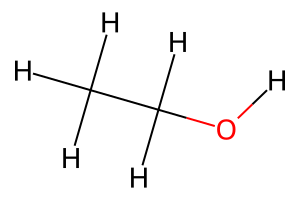

In [2]:
# Create an ethanol molecule for basic examples
ethanol = molify.smiles2atoms("CCO")
print(f"Ethanol has {len(ethanol)} atoms")
print(f"Chemical formula: {ethanol.get_chemical_formula()}")

# Visualize the structure
ethanol_mol = molify.ase2rdkit(ethanol)
Draw.MolToImage(ethanol_mol, size=(300, 200))

In [3]:
# Match carbon atoms using SMILES pattern
carbon_matches = molify.match_substructure(ethanol, smiles="C")
print(f"Carbon atom matches: {carbon_matches}")
print(f"Number of carbon matches: {len(carbon_matches)}")

# Match the hydroxyl group (O-H)
hydroxyl_matches = molify.match_substructure(ethanol, smiles="O")
print(f"\nHydroxyl oxygen matches: {hydroxyl_matches}")

Carbon atom matches: ()
Number of carbon matches: 0

Hydroxyl oxygen matches: ()


In [4]:
# Use SMARTS for more specific pattern matching
# Match only sp3 carbon atoms (aliphatic carbons with single bonds)
sp3_carbons = molify.match_substructure(ethanol, smarts="[C;X4]")
print(f"sp3 carbon matches: {sp3_carbons}")

# Match oxygen with exactly one hydrogen (hydroxyl group)
hydroxyl_oxygen = molify.match_substructure(ethanol, smarts="[OH1]")
print(f"Hydroxyl oxygen: {hydroxyl_oxygen}")

sp3 carbon matches: ((0,), (1,))
Hydroxyl oxygen: ((2,),)


### Multiple Matches in Complex Molecules

When a pattern occurs multiple times in a molecule, `match_substructure` returns all matches as a tuple of tuples, where each inner tuple contains the atom indices for one match.

All carbon matches in propanol: ()
Total carbon atoms found: 0

C-C-O pattern matches: ()


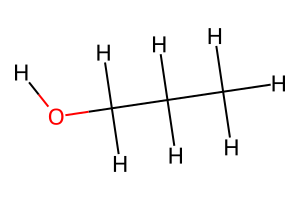

In [5]:
# Create propanol with multiple carbon atoms
propanol = molify.smiles2atoms("CCCO")
propanol_mol = molify.ase2rdkit(propanol)

# Find all methyl groups (CH3)
methyl_matches = molify.match_substructure(propanol, smiles="C")
print(f"All carbon matches in propanol: {methyl_matches}")
print(f"Total carbon atoms found: {len(methyl_matches)}")

# Find the C-C-O pattern
cco_pattern = molify.match_substructure(propanol, smiles="CCO")
print(f"\nC-C-O pattern matches: {cco_pattern}")

# Visualize
Draw.MolToImage(propanol_mol, size=(300, 200))

## Advanced Atom Selection with `select_atoms_grouped`

While `match_substructure` provides basic pattern matching, `select_atoms_grouped` offers advanced capabilities for more sophisticated selection tasks:

- **Fragment-aware grouping**: Automatically groups selections by disconnected molecular fragments
- **Hydrogen handling**: Three modes (exclude, include, isolated) for precise control over hydrogen inclusion
- **Atom mapping**: Support for mapped SMILES patterns with guaranteed atom ordering
- **RDKit integration**: Works directly with RDKit Mol objects for seamless integration

This function is particularly useful when working with multi-fragment systems or when precise control over hydrogen atoms is required.

### Basic Selection with SMARTS Patterns

The fundamental usage of `select_atoms_grouped` involves providing an RDKit Mol object and a SMARTS or SMILES pattern. Results are grouped by disconnected molecular fragments.

In [6]:
# Select all carbon atoms using atomic number in SMARTS
carbon_indices = molify.select_atoms_grouped(ethanol_mol, "[#6]")
print(f"Carbon atom indices: {carbon_indices}")

# Select the oxygen atom
oxygen_indices = molify.select_atoms_grouped(ethanol_mol, "[#8]")
print(f"Oxygen atom indices: {oxygen_indices}")

Carbon atom indices: [[0, 1]]
Oxygen atom indices: [[2]]


### Fragment-Aware Grouping

When working with molecules containing multiple disconnected fragments, `select_atoms_grouped` automatically organizes selections by fragment. Each fragment's matched atoms are returned as a separate list.

In [7]:
# Combine two ethanol molecules into a single Mol object
multi_fragment_mol = CombineMols(ethanol_mol, ethanol_mol)

# Select carbon atoms - results are grouped by fragment
carbon_indices = molify.select_atoms_grouped(multi_fragment_mol, "[#6]")
print(f"Carbon indices grouped by fragment: {carbon_indices}")
print(f"Fragment 1 carbons: {carbon_indices[0]}")
print(f"Fragment 2 carbons: {carbon_indices[1]}")

Carbon indices grouped by fragment: [[0, 1], [9, 10]]
Fragment 1 carbons: [0, 1]
Fragment 2 carbons: [9, 10]


### Hydrogen Handling Modes

The function provides three modes for controlling hydrogen atom inclusion in selections:

- **`exclude`** (default): Returns only heavy atoms, excluding all hydrogens
- **`include`**: Returns heavy atoms followed by their bonded hydrogens
- **`isolated`**: Returns only the hydrogen atoms bonded to selected heavy atoms

This capability is particularly useful in molecular dynamics simulations and quantum chemical calculations where explicit hydrogen control is required.

In [8]:
# Select the C-O bond pattern with different hydrogen handling
pattern = "CO"  # Carbon-Oxygen bond

# Default: exclude hydrogens
exclude_h = molify.select_atoms_grouped(ethanol_mol, pattern, hydrogens="exclude")
print(f"Exclude hydrogens: {exclude_h}")

# Include hydrogens attached to matched heavy atoms
include_h = molify.select_atoms_grouped(ethanol_mol, pattern, hydrogens="include")
print(f"Include hydrogens: {include_h}")

# Return only the hydrogens attached to matched heavy atoms
isolated_h = molify.select_atoms_grouped(ethanol_mol, pattern, hydrogens="isolated")
print(f"Isolated hydrogens: {isolated_h}")

Exclude hydrogens: [[1, 2]]
Include hydrogens: [[1, 6, 7, 2, 8]]
Isolated hydrogens: [[6, 7, 8]]


### Mapped SMILES Patterns and Atom Ordering

Mapped SMILES patterns provide precise control over which atoms are selected and their ordering in the output. When atom map numbers are specified (e.g., `[C:1]`, `[C:2]`), only the mapped atoms are returned, ordered by their map numbers in ascending order.

This feature enables deterministic atom ordering for applications requiring specific atom sequences, such as distance measurements, dihedral angle calculations, or constraint definitions in molecular simulations.

In [9]:
# Using mapped SMILES to select only specific atoms
# This pattern matches the carbon-carbon-oxygen chain,
# but only returns the mapped carbons in the specified order
mapped_pattern = "[C:1][C:2]O"
mapped_indices = molify.select_atoms_grouped(ethanol_mol, mapped_pattern)
print(f"Mapped carbon indices: {mapped_indices}")

# Compare with unmapped pattern which returns all atoms in the match
unmapped_pattern = "CCO"
unmapped_indices = molify.select_atoms_grouped(ethanol_mol, unmapped_pattern)
print(f"Unmapped pattern indices: {unmapped_indices}")

# Demonstrate atom ordering control with alanine dipeptide
aladip = molify.smiles2atoms("CC(=O)NC(C)C(=O)NC")
aladip_mol = molify.ase2rdkit(aladip)

# Select atoms in map order 1, 2, 3, 4
indices_1234 = molify.select_atoms_grouped(
    aladip_mol, "CC(=O)N[C:1]([C:2])[C:3](=O)[N:4]C"
)
print(f"\nMap order 1,2,3,4: {indices_1234}")

# Select the same atoms but in different map order 4, 3, 2, 1
indices_4321 = molify.select_atoms_grouped(
    aladip_mol, "CC(=O)N[C:4]([C:3])[C:2](=O)[N:1]C"
)
print(f"Map order 4,3,2,1: {indices_4321}")

Mapped carbon indices: [[0, 1]]
Unmapped pattern indices: [[0, 1, 2]]

Map order 1,2,3,4: [[4, 5, 6, 8]]
Map order 4,3,2,1: [[8, 6, 5, 4]]


### Visualization of Atom Selections

The `visualize_selected_molecules` function provides visual feedback for atom selections by highlighting selected atoms in molecular structure depictions. Multiple selection sets can be simultaneously visualized with distinct color coding, facilitating comparison and validation of selection patterns.

Aromatic carbons: [[1, 2, 3, 4, 5, 6]]
Methyl carbon: [[0]]


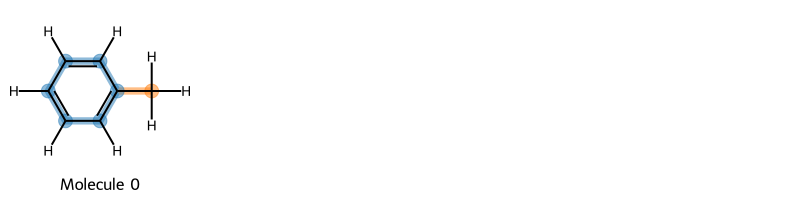

In [10]:
# Create toluene molecule for visualization examples
toluene_smiles = "Cc1ccccc1"
toluene_mol = molify.ase2rdkit(molify.smiles2atoms(toluene_smiles))

# Select different atom types
aromatic_carbons = molify.select_atoms_grouped(toluene_mol, "c", hydrogens="exclude")
methyl_carbon = molify.select_atoms_grouped(toluene_mol, "[C;!c]", hydrogens="exclude")

print(f"Aromatic carbons: {aromatic_carbons}")
print(f"Methyl carbon: {methyl_carbon}")

# Visualize with highlighted selections
img = molify.visualize_selected_molecules(
    toluene_mol, aromatic_carbons[0], methyl_carbon[0]
)
img

### Functional Group Selection in Complex Molecules

The advanced selection capabilities can be applied to identify and isolate functional groups within complex molecular structures. The following example demonstrates multi-pattern selection in aspirin (acetylsalicylic acid), highlighting different functional groups with independent color coding.

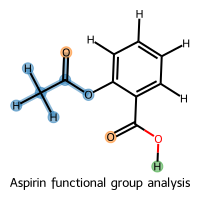

In [11]:
# Aspirin (acetylsalicylic acid) contains multiple functional groups
aspirin_smiles = "CC(=O)Oc1ccccc1C(=O)O"
aspirin_mol = molify.ase2rdkit(molify.smiles2atoms(aspirin_smiles))

# Visualize with multiple functional group highlights
molify.visualize_selected_molecules(
    aspirin_mol,
    # Acetyl ester group with hydrogens
    molify.select_atoms_grouped(
        aspirin_mol, "[C:1][C:2](=O)[O:4]c1ccccc1C(=O)O", hydrogens="include"
    )[0],
    # Carbonyl oxygens
    molify.select_atoms_grouped(aspirin_mol, "[O:1]=C")[0],
    # Carboxylic acid hydrogens
    molify.select_atoms_grouped(aspirin_mol, "CO", hydrogens="isolated")[0],
    mols_per_row=1,
    legends=["Aspirin functional group analysis"],
)